In [8]:
import pandas as pd
import numpy as np
import glob, sys, os, time , itertools , warnings , re , json
from bs4 import BeautifulSoup
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing as mp
from scipy import stats
# from DataProcessing import 
import uszipcode , pickle 
from TempFolder.TempFolder import Temp


import plotly.figure_factory as ff
# importing all necessary libraries 
import chart_studio.plotly as py 
import plotly.graph_objs as go 
import pandas as pd 
  
# some more libraries to plot graph 
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot 
# To establish connection 
init_notebook_mode(connected = True) 


warnings.filterwarnings('ignore')

with open('nogit\\path','r') as f:
    path_to_csv = f.read()
path_to_processed_csv =path_to_csv + 'SC-csv\\'
Temp.set_path(path_to_csv +'SC-temp\\')
path_to_temp_csv = path_to_csv+'SC-working-folder\\'
colummn_names = ['Description'
                 ,'Title State/Type'
                 ,'Location'
                 ,'null'
                 ,'Auction Date'
                 ,'Actual Cash Value'
                 ,'Repair Cost'
                 ,'Odometer'
                 ,'Prim Damage'
                 ,'Sec Damage'
                 ,'Price Sold or Highest Bid']
path_to_makes = glob.glob(path_to_csv+'Cars\\*')
path_to_all_years = list(itertools.chain.from_iterable([glob.glob(path+'\\*') for path in path_to_makes]))


out_df = Temp.load_obj('out_df_working')

car_demo_joined = Temp.load_obj('car_demo_joined')

Object <out_df_working> loaded from: c:\data\Datasets\SC-temp\
Object <car_demo_joined> loaded from: c:\data\Datasets\SC-temp\


In [9]:
#fetech counties with no data 
empty_fips = ( pd.merge(out_df,pd.read_csv(path_to_csv +'Us-zipcodes\\fips_codes.csv',index_col=0)
                .assign(state_fibs = lambda x: x['County'].str.split(', ',expand=True)[1])
                , on='County',how='outer')
                .loc[lambda x: x['make_key'].isna(),['FIPS_y','state_fibs']]
                .drop_duplicates()
                .reset_index(drop=True))

# empty_fips

In [10]:
def geo_plot_county(df: pd.DataFrame,states=None,make=None,model=None,model_year=None,auction_year=None):
    import traceback
    if states:
        df = df.loc[out_df['State']==states[0]]
        empty_fips_state = empty_fips.loc[empty_fips.state_fibs ==states[0],'FIPS_y'].values.tolist()
    else:
        states = ['USA']
        empty_fips_state = empty_fips['FIPS_y'].values.tolist()
    try:
        filtred = df.loc[(df['Make'] == make)]
        
        if model:
            filtred = filtred.loc[(filtred['Model_short'] == model) ]
        if model_year:
            filtred = filtred.loc[
            (filtred['Model_Year'] == model_year)]
        else:
            model_year = ''
        if auction_year:
            filtred = filtred.loc[(filtred['Auction_Year'] == auction_year)]
        else:
            auction_year = ''
        
        #extract state
        # filtred = (filtred.drop('State',axis=1)
        #             .join(filtred['County'].str.split(', ',expand=True)[1]
        #             .rename('State')))
        
        
        l = filtred.groupby('FIPS')['Price_Sold_or_Highest_Bid'].mean().round().to_dict().items()
        fips , values = map(list , zip(*l) )
        
        #add empty counties
        fips.extend(empty_fips_state)
        values.extend([0] * len(empty_fips_state))
        # import pdb; pdb.set_trace()
        n = np.max(values)
        colorscale=["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1","#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be",      
                     "#2171b5","#1361a9","#08519c","#0b4083","#08306b"
                     ]
        
        # colorscale = [
        #     'rgb(68.0, 1.0, 84.0)',
        #     'rgb(66.0, 64.0, 134.0)',
        #     'rgb(38.0, 130.0, 142.0)',
        #     'rgb(63.0, 188.0, 115.0)',
        #     'rgb(216.0, 226.0, 25.0)',
        #     'rgb(255.0, 130.0, 100.0)',
        #     'rgb(8.,81.,156.)',
        #     'rgb(179,210,233)'
            
        # ]

        endpts = list(np.linspace(1, n, len(colorscale) - 1))
        
        
        fig = ff.create_choropleth(
            fips=fips, values=values,
            binning_endpoints=endpts,
            colorscale=colorscale,
            county_outline={'color': 'black', 'width': 0.5},
            state_outline={'width': 1,'color': 'black',},
            scope=states,
            round_legend_values=True,
            show_state_data=True,
            show_hover=True, centroid_marker={'opacity': 0},
            asp=2.9, title='Price_Sold_or_Highest_Bid by USA County',
            legend_title='Price_Sold_or_Highest_Bid'
        )

        fig.layout.template = None
        fig.layout.xaxis.fixedrange = False 
        fig.layout.yaxis.fixedrange = False 
        fig.show()


        fig.write_image(f"png/bycounty_{auction_year}-{make}-{model}-{model_year}.png")

    except Exception as e:
        print('Error:', e,traceback.format_exc())
        return filtred

In [11]:
model_year = None#2007
auction_year =None# 2018
make = 'TOYOTA'
model = 'CAMRY'
# states = ['CA','AZ','OR','NV']

states = ['CA']
filtred = geo_plot_county(out_df,states,make,model,model_year,auction_year)

In [12]:
states = ['IL']
filtred = geo_plot_county(out_df,states,make,model,model_year,auction_year)

In [30]:
out_df.columns

Index(['Actual_Cash_Value', 'Auction_Date', 'Description', 'Location',
       'Odometer', 'Price_Sold_or_Highest_Bid', 'Prim_Damage', 'Repair_Cost',
       'Sec_Damage', 'Title_State_Type', 'Model_Year', 'Make', 'Model', 'City',
       'Auction_Year', 'Model_short', 'Odometer_Null', 'Odometer_Replace',
       'Model_Age', 'County', 'make_key', 'Actual_Cash_Value_adj',
       'Price_Sold_or_Highest_Bid_adj', 'Repair_Cost_adj', 'FIPS', 'State'],
      dtype='object')

In [32]:
exp_columns = ['Actual_Cash_Value',	'Price_Sold_or_Highest_Bid',	'Repair_Cost',	'Model_Age',	'Odometer_Null'	,'Auction_Year']
pop_means = out_df[exp_columns].mean()
pop_means

Actual_Cash_Value             11609.094284
Price_Sold_or_Highest_Bid      3402.139614
Repair_Cost                   10655.892726
Model_Age                        10.413666
Odometer_Null                108766.369916
Auction_Year                   2016.549355
dtype: float64

In [33]:
# t_stats.ttest_1samp
def ttest(df):
    return df.apply(lambda x: round(stats.ttest_1samp(x.dropna().values,pop_means[x.name])[1],3) )

def signific(v):
    if v < 0.01:
        return '***'
    elif v < 0.05:
        return '**'
    elif v < 0.1:
        return '*'
    else:
        return ''


In [34]:
#value distribution for Prim Damage 
def cond_on(on='Prim_Damage'):
    on_count = (out_df[on]
    .value_counts()
    .rename('Count')
    .to_frame())

    cond_on_t =(on_count.join(out_df.groupby(on)[exp_columns]
    .apply(ttest)).dropna()
    .sort_values(by='Count',ascending=False)
    .drop(columns='Count')
    .applymap(signific)
    )


    prim_val_dist = out_df[on].value_counts()

    #summary statistics conditions on on
    cond_on_primd = out_df.groupby(on)[exp_columns].agg(['mean']).stack().sort_index(level=1)
    cond_on_primd.index = [i for i, j in cond_on_primd.index]

    

    cond_on = (cond_on_primd.join(on_count)
        .sort_values(by='Count',ascending=False)
        .dropna()
        .astype(int)
        [['Count'] + exp_columns]
    )

    #cond_on

    return on_count.join(pd.concat([ cond_on[col].astype(str)+ cond_on_t[col].astype(str)     for col in exp_columns] , axis=1)).dropna()

In [35]:
cond_on(on='Prim_Damage')

,Count,Actual_Cash_Value,Price_Sold_or_Highest_Bid,Repair_Cost,Model_Age,Odometer_Null,Auction_Year
front end,398126,12413***,3230***,10849***,8***,93323***,2016***
rear end,95650,10794***,3158***,9564***,9***,103239***,2016***
mechanical,90439,5828***,1839***,6866***,13***,158305***,2016***
side,84045,11662,3459*,10154***,9***,99922***,2016***
minor dent/scratches,82229,6561***,2835***,5748***,14***,159497***,2017***
normal wear,46476,11125***,4886***,2956***,14***,147264***,2015***
all over,29316,14725***,3514***,13885***,8***,85716***,2016***
water/flood,29199,19795***,7174***,11961***,7***,74769***,2016***
minor dents/scratche,22681,9477***,3896***,3190***,13***,154259***,2013***
hail,11660,10010***,3885***,9087***,10***,102097***,2016***


In [36]:
cond_on(on='Make')

,Count,Actual_Cash_Value,Price_Sold_or_Highest_Bid,Repair_Cost,Model_Age,Odometer_Null,Auction_Year
TOYOTA,129502,10179***,3434**,10485***,10***,123581***,2016***
HONDA,98616,9696***,2578***,10237*,10***,117059***,2016***
FORD,88578,9936***,2468***,9675***,10,109004,2016***
NISSAN,80858,9919***,2516***,10337***,8***,100834***,2016***
CHEVROLET,68224,11289***,2962***,10472***,10***,98992***,2016**
HYUNDAI,40016,9826***,2579***,10293***,7***,92644***,2016***
DODGE,37610,10313***,2636***,9912***,9***,110443***,2016***
BMW,36750,17928***,6064***,13293***,10***,100821***,2016***
MERCEDES-BENZ,35932,21492***,7760***,14516***,11***,96086***,2016***
JEEP,35342,12354***,3610***,11062***,10***,107383***,2016***


In [42]:
cond_on(on='Auction_Year')

,Count,Actual_Cash_Value,Price_Sold_or_Highest_Bid,Repair_Cost,Model_Age,Odometer_Null,Auction_Year
2019,205517,10986***,3005***,10254***,10***,110133***,2019***
2018,193701,10203***,3019***,10339***,10***,109137*,2018***
2017,128116,12195***,3387,10971***,9***,98269***,2017***
2016,126399,11881***,3120***,11133***,9***,103239***,2016***
2015,103078,12141***,3462***,10815**,9***,107893***,2015***
2014,93942,12123***,3734***,10230***,10***,116909***,2014***
2013,70720,14233***,4776***,10390***,10**,119767***,2013***
2012,24986,14045***,5565***,9756***,10***,121516***,2012***
2011,1326,17481***,6153***,33341,8***,87199***,2011***
2010,260,17931***,5769***,9937,7***,75888***,2010***


In [5]:

numerical_fields =  ['Actual_Cash_Value_adj'
               ,'Auction_Year'
       #'Odometer'
       , 'Price_Sold_or_Highest_Bid_adj'
       , 'Repair_Cost_adj'
        ,'Odometer_Null','Odometer_Replace'
        ,'Model_Age'
        ,'Original_MSRP_mean_adj'
        ,'Unemp_pct_null'
        ,'Unemp_pct_closest',
         'Income_adj_null',
        'Income_adj_closest',
        'CENSUS_null',
        'CENSUS_closest',
        'GRNDTOT_null',
        'GRNDTOT_closest',
        'CPOPARST_null',
        'CPOPARST_closest'
        ]

categorical_variables = ['Prim_Damage','Make','Model'
]

marching_cols = ['Price_Sold_or_Highest_Bid_adj','Make','Model_short','Model_Age']

In [16]:
car_demo_joined_describe = car_demo_joined[numerical_fields].describe(percentiles =[.01,.25, .5, .75,.99]).T

car_demo_joined_describe.to_csv('csv/summary_statistics2.csv')

car_demo_joined_describe#.astype(int)

,count,mean,std,min,1%,25%,50%,75%,99%,max
Actual_Cash_Value_adj,381613.0,1.190545e+04,1.159911e+04,100.000000,1200.000000,5250.000000,8737.000000,1.475500e+04,5.334928e+04,1.000000e+06
Auction_Year,470264.0,2.016740e+03,1.999382e+00,2010.000000,2012.000000,2015.000000,2017.000000,2.018000e+03,2.019000e+03,2.019000e+03
Price_Sold_or_Highest_Bid_adj,470264.0,3.322223e+03,6.482390e+03,1.000000,225.000000,850.000000,1800.000000,3.750000e+03,2.300000e+04,2.000000e+06
Repair_Cost_adj,186746.0,1.079659e+04,9.630435e+03,0.170000,1259.391500,6331.000000,9433.000000,1.337500e+04,3.355000e+04,9.999990e+05
Odometer_Null,301378.0,1.044171e+05,6.857837e+04,0.000000,1766.770000,51242.000000,100594.000000,1.483148e+05,2.753130e+05,9.600091e+06
Odometer_Replace,469086.0,1.739951e+05,1.883908e+05,0.000000,2884.000000,75451.250000,142851.000000,2.417260e+05,5.265670e+05,9.600091e+06
Model_Age,470264.0,9.333194e+00,4.565471e+00,0.000000,1.000000,5.000000,10.000000,1.300000e+01,1.900000e+01,2.000000e+01
Original_MSRP_mean_adj,467743.0,2.977521e+04,1.334846e+04,9390.000000,13160.000000,22090.000000,26755.000000,3.430000e+04,7.652500e+04,4.731500e+05
Unemp_pct_null,286415.0,5.029048e+00,1.581242e+00,2.200000,2.500000,3.900000,4.700000,5.800000e+00,1.020000e+01,1.670000e+01
Unemp_pct_closest,374804.0,4.762537e+00,1.530383e+00,2.200000,2.500000,3.700000,4.400000,5.400000e+00,9.700000e+00,1.670000e+01


In [2]:
#matching estimator
car_demo_joined['Auction_Year'].value_counts().to_frame().reset_index().rename({'index':'year','Auction_Year':'# obs'},axis=1)

,year,# obs
0,2019,214803
1,2018,201296
2,2017,132662
3,2016,130940
4,2015,106973
5,2014,98202
6,2013,72876
7,2012,25720
8,2011,1368
9,2010,264


In [3]:
car_demo_joined.loc[car_demo_joined['Make'] == 'TOYOTA','Model_short'].unique()

array(['4RUNNER', 'CAMRY', 'AVALON', 'COROLLA', 'RAV4', 'SIENNA',
       'CELICA', 'MR2', 'PRIUS', 'HIGHLANDER', 'ECHO', 'SEQUOIA',
       'CORROLA', 'MATRIX/XR', 'COROLLA/MA', 'YARIS', 'FJ', 'CAMRY/SE/L',
       'COROLLA/S/', 'COROLLA/LE', 'TACOMA', 'SCION', 'COR', 'DELUXE',
       'CRESSIDA', 'LANDCRUISE', 'SUPRA', 'LAND', 'PREVIA', 'TERCEL',
       'MATRIX', 'VENZA', '86', 'COROLLA/DX', 'LANDCRUISR', 'HIGLANDER',
       'AVALON/LIM', 'C-HR', 'SR5', 'PASEO', 'SIENNA/LE', '4RUNNER/SR',
       'TUNDRA', 'RAV', 'VAN', 'EXTRA', 'CELICA/ST', 'T100', 'SOLARA',
       'XB', 'CORONA', 'PREVIA/DX', 'HIGHLNDER', 'AV', 'CAMRY/DX', 'CAM',
       'PICKUP', 'SHORT', 'TUNDRA/SR5', 'CAMRY/LE/X', 'FJ40', 'CAB',
       'HILUX', 'OTHER', 'PICK', 'STARLET', 'IA', 'DOLPHIN', 'FR-S',
       'MIRAI', 'PICK-UP', 'STANDARD', 'CAMRY-LE', 'CORROLLA', 'ARISTO',
       'SEABREEZE', 'ALL', 'COROLL', 'LONG', 'SIENNA/CE', 'SKID', '2DR',
       '1/2', 'TRUCK'], dtype=object)

In [4]:
subsample = car_demo_joined.loc[car_demo_joined['Auction_Year'] == 2018]


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Population, M'),
 Text(0.5, 1.0, 'Population Distribution')]

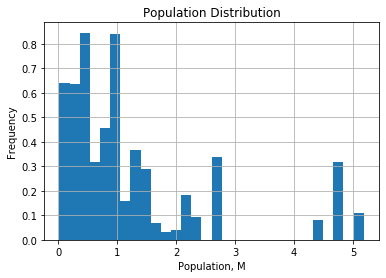

In [5]:
ax =( subsample['CENSUS_closest'].dropna() / 1e6).hist(bins=30,normed=True)

ax.set(title = 'Population Distribution', xlabel='Population, M', ylabel='Frequency')

In [6]:
subsample.loc[subsample['CENSUS_closest']<1e6 , 'is_big_city'] = 0
subsample.loc[subsample['CENSUS_closest']>1e6 , 'is_big_city'] = 1

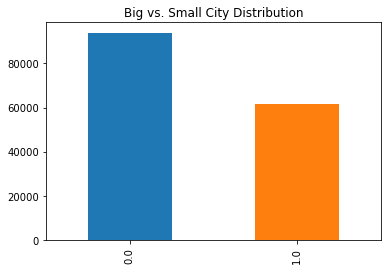

In [7]:
subsample['is_big_city'].value_counts().plot.bar(title='Big vs. Small City Distribution')

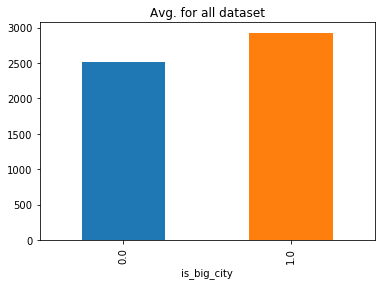

In [8]:
subsample.groupby('is_big_city')['Price_Sold_or_Highest_Bid_adj'].mean().plot.bar(title='Avg. for all dataset')

In [10]:
subsample.columns

Index(['Actual_Cash_Value', 'Auction_Date', 'Price_Sold_or_Highest_Bid',
       'Prim_Damage', 'Repair_Cost', 'Model_Year', 'Make', 'Model',
       'Auction_Year', 'Model_short', 'Odometer_Null', 'Odometer_Replace',
       'Model_Age', 'County', 'Actual_Cash_Value_adj',
       'Price_Sold_or_Highest_Bid_adj', 'Repair_Cost_adj', 'FIPS',
       'Original_MSRP_low', 'Original_MSRP_high', 'Original_MSRP_mean',
       'Original_MSRP_mean_adj', 'index', 'Unemp_pct_null',
       'Unemp_pct_closest', 'Income_adj_null', 'Income_adj_closest',
       'CENSUS_null', 'CENSUS_closest', 'GRNDTOT_null', 'GRNDTOT_closest',
       'CPOPARST_null', 'CPOPARST_closest', 'is_big_city'],
      dtype='object')

In [11]:
subsample.head()

,Actual_Cash_Value,Auction_Date,Price_Sold_or_Highest_Bid,Prim_Damage,Repair_Cost,Model_Year,Make,Model,Auction_Year,Model_short,...,Unemp_pct_closest,Income_adj_null,Income_adj_closest,CENSUS_null,CENSUS_closest,GRNDTOT_null,GRNDTOT_closest,CPOPARST_null,CPOPARST_closest,is_big_city
8,26670.0,2018-09-29,3200.0,water/flood,21775.0,2018,NISSAN,ROGUE S,2018,ROGUE,...,3.3,NaN,41590.943897,323780.0,323780.0,NaN,15677.0,NaN,317853.0,0.0
9,NaN,2018-05-14,400.0,minor dent/scratches,NaN,1999,OLDSMOBILE,ALERO GL,2018,ALERO,...,3.3,NaN,41590.943897,323780.0,323780.0,NaN,15677.0,NaN,317853.0,0.0
25,NaN,2018-07-30,6000.0,normal wear,NaN,1966,PLYMOUTH,FURY NAN,2018,FURY,...,3.3,NaN,41590.943897,323780.0,323780.0,NaN,15677.0,NaN,317853.0,0.0
87,6229.0,2018-02-07,675.0,front end,4305.0,2008,PONTIAC,G6 BASE,2018,G6,...,3.3,NaN,41590.943897,323780.0,323780.0,NaN,15677.0,NaN,317853.0,0.0
88,5811.0,2018-01-24,350.0,front end,5426.0,2006,PONTIAC,TORRENT NAN,2018,TORRENT,...,3.3,NaN,41590.943897,323780.0,323780.0,NaN,15677.0,NaN,317853.0,0.0


In [5]:
#find match candidates 
car_demo_joined.loc[car_demo_joined['CENSUS_closest']<1e6 , 'is_big_city'] = 0
car_demo_joined.loc[car_demo_joined['CENSUS_closest']>1e6 , 'is_big_city'] = 1

def find_match_expected(small_c, big_c):
    def find_match_for_row(x):
        # try:
        bs = big_c.copy()
        # import pdb; pdb.set_trace()
        bs['Actual_Cash_Value_adj'] = np.abs((x['Actual_Cash_Value_adj']/bs['Actual_Cash_Value_adj'])-1)
        bs['Odometer_Replace']  = np.abs((x['Odometer_Replace']/bs['Odometer_Replace'])-1)
        bs['Original_MSRP_mean']  = np.abs((x['Original_MSRP_mean']/bs['Original_MSRP_mean'])-1)
        bs = bs.fillna(9999)
        return bs.loc[
                        (bs.Actual_Cash_Value_adj  <=.1 )
                        & (bs.Odometer_Replace <=.1)
                        & (bs.Original_MSRP_mean <=.1)
                        ].index.tolist()

        # except: return []
    # import pdb; pdb.set_trace()
    return small_c.apply(find_match_for_row,axis=1)
    
match_l = []
i = 0 
for grp , df in tqdm(car_demo_joined.groupby(['Make','Model_short','Model_Age','Prim_Damage','Auction_Year'])):
    if len(df) <2:
        continue
    is_big_city_bs = df.loc[df.is_big_city == 1]
    is_small_city_df = df.loc[df.is_big_city == 0]

    match_l.append(find_match_expected(is_small_city_df,is_big_city_bs))
    i+=1

    # if i>550:
    #     break


match_null = pd.concat(match_l).dropna(axis=1).iloc[:,0].rename('match')




Temp.save_obj(match_null,'expected_match_indexed')

1%|          | 1168/211024 [00:08<20:56, 167.05it/s]Object <1893195431880> saved to: c:\data\Datasets\SC-temp\


In [15]:
match_null = Temp.load_obj('expected_match_indexed')
match_e = match_null.loc[match_null.map(lambda x: len(x)>0)]
print('% of records that matched: ', 100*len(match_e) / len(match_null),'%\n',match_e.head()
,'# of recoreds that matched:', match_e.shape
)

#ex pet of c,match_null.shape[0]ted match

def expect# ed_mean(idx):
    return#  car_demo_joined.loc[idx,'Price_Sold_or_Highest_Bid_adj'].mean()

expected_m# atch = (match_e.apply(expected_mean).rename('expected_value_big_city').to_frame()
.join(car_# demo_joined.Price_Sold_or_Highest_Bid_adj.rename('actual_value_small_city'))) ; expected_match


Temp.save_# obj(expected_match,'expected_match')


Object <expected_match_indexed> loaded from: c:\data\Datasets\SC-temp\
% of records that matched:  9.805485420521562 %
 576193    [128555]
370474    [384010]
468937    [384010]
427613    [128500]
427677    [190502]
Name: match, dtype: object # of recoreds that matched: (43030,)
Object <2205543080712> saved to: c:\data\Datasets\SC-temp\


In [7]:

expected_match = Temp.load_obj('expected_match')
#calculate difference 
expected_match_diff = expected_match.diff(axis=1).dropna(axis=1).abs()

#calc statistics
print(expected_match_diff.agg(['mean','std']) ,'\nt-test p value:', round(stats.ttest_1samp(expected_match_diff.values.reshape(-1,),0)[1],3),'\n',expected_match.head())


Object <expected_match> loaded from: c:\data\Datasets\SC-temp\
      actual_value_small_city
mean               787.257531
std               1306.281468 
t-test p value: 0.0 
         expected_value_big_city  actual_value_small_city
576193                   2400.0                   4050.0
370474                  11600.0                  11900.0
468937                  11600.0                   4600.0
427613                   3750.0                   3850.0
427677                   3400.0                   2000.0


In [44]:
#define the matching model (logistic regression)
from pymatch.Matcher import Matcher
from tqdm import tqdm
match_acc = dict()
#for each group (which is defined as low/ high population county) find a match based on the following variables:
#Make (exacte), Model(exact) , Prim Damage (exact), Actual_Cash_value/Odometer/MSRP (within 10%).
for name , subsample_uniqe in tqdm(subsample.groupby(['Make','Model_short'#,'Model_Age'
                                                ])):
    try:
        print(f'\nmatchign {name}...')
        test = subsample_uniqe.loc[subsample['is_big_city'] == 0]
        control = subsample_uniqe.loc[subsample['is_big_city'] == 1]
        m = Matcher(test, control, yvar="is_big_city", exclude=['CENSUS_closest','Make','Model_short','Model_Age'])
        m.fit_scores(balance=True, nmodels=100)
        match_acc[name] =np.mean(m.model_accuracy)
        # m.predict_scores()
        # m.plot_scores()
        # break
    except: pass
match_acc_df = pd.DataFrame.from_dict(match_acc,orient='index').rename({0:'matching_accuracy'},axis=1)

age Accuracy: 51.91%

matchign ('MERCEDES-BENZ', 'E-CLASS')...
Formula:
is_big_city ~ Price_Sold_or_Highest_Bid_adj
n majority: 1
n minority: 0
Fitting Models on Balanced Samples: 1\100
matchign ('MERCEDES-BENZ', 'GLA')...
Formula:
is_big_city ~ Price_Sold_or_Highest_Bid_adj
n majority: 24
n minority: 24
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 50.0%

matchign ('MERCEDES-BENZ', 'GLC')...
Formula:
is_big_city ~ Price_Sold_or_Highest_Bid_adj
n majority: 24
n minority: 14
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 49.79%

matchign ('MERCEDES-BENZ', 'GLE')...
Formula:
is_big_city ~ Price_Sold_or_Highest_Bid_adj
n majority: 27
n minority: 16
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 53.44%

matchign ('MERCEDES-BENZ', 'GLK')...
Formula:
is_big_city ~ Price_Sold_or_Highest_Bid_adj
n majority: 83
n minority: 70
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 55.49%

matchign ('MERCEDES-BENZ', 'GLS')...
Formula:
is_big_ci

In [48]:
Temp.save_obj(match_acc_df,'match_acc_df')

Object <2479144533832> saved to: c:\data\Datasets\SC-temp\


,matching_accuracy
count,304.000000
mean,0.566000
std,0.064668
min,0.443214
25%,0.521991
50%,0.550458
75%,0.594550
max,0.882500


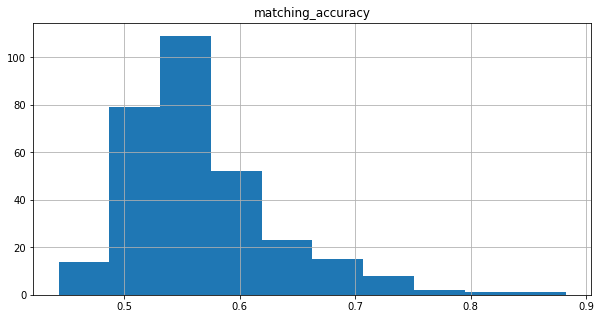

In [47]:
match_acc_df.hist()

match_acc_df.describe()